In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import itertools
import math


load the text of demon slayer wikipedia page

In [61]:
with open("demonslayer.txt", "r", encoding="utf-8") as f:
    text = f.read()

words = text.split()

# build vocab
vocab = sorted(set(words))
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

data = [word_to_idx[word] for word in words]

print(f"Dataset size: {len(data)} words")
print(f"Vocabulary size: {vocab_size} unique words")

Dataset size: 3795 words
Vocabulary size: 1523 unique words



Build LSTM model

In [62]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)  # Word embedding layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)  # Output layer
    
    def forward(self, x, hidden):
        x = self.embedding(x)  # Convert word indices to embeddings
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)  # Map LSTM outputs to vocab probabilities
        return output, hidden


Create dataset for word-level sequences

In [63]:
from torch.utils.data import Dataset, DataLoader

class WordDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data  # data is a list of word indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx + 1:idx + self.seq_len + 1], dtype=torch.long)
        return x, y
    
    
# Split data into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]


helper functions

In [64]:
def evaluate_validation(model, val_loader, criterion, num_layers, hidden_size):
    """
    evaluates the model using validation data 
    
    calculates:
        avg_val_loss: average cross-entropy loss
        val_perplexity: perplexity
    """
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            hidden = (torch.zeros(num_layers, x_batch.size(0), hidden_size),
                      torch.zeros(num_layers, x_batch.size(0), hidden_size))
            output, hidden = model(x_batch, hidden)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    return avg_val_loss, val_perplexity


def evaluate_test(model, test_loader, criterion, num_layers, hidden_size):
    """
    calculates:
        avg_test_loss: average cross-entropy loss
        test_perplexity: perplexity on the test set
    """
    model.eval()  # evaluation mode
    total_loss = 0
    
    with torch.no_grad():  # no gradients needed
        for x_batch, y_batch in test_loader:
            hidden = (torch.zeros(num_layers, x_batch.size(0), hidden_size),
                      torch.zeros(num_layers, x_batch.size(0), hidden_size))
            output, hidden = model(x_batch, hidden)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            total_loss += loss.item()
    
    avg_test_loss = total_loss / len(test_loader)
    test_perplexity = math.exp(avg_test_loss)
    return avg_test_loss, test_perplexity


def generate_text(model, start_text, max_len=200, temperatures=[0.7,1.0,1.3]):
    
    """
    generate text for 3 temperates: 0.7, 1.0, 1.3
    """
    
    model.eval()
    
    # split start text into words and convert to indices
    start_words = start_text.split()
    input_ids_orig = torch.tensor([[word_to_idx.get(word, 0) for word in start_words]], dtype=torch.long)
    
    results = {} 
    
    for temp in temperatures:
        generated_words = start_words.copy()
        input_ids = input_ids_orig.clone()
        hidden = None

        for _ in range(max_len):
            output, hidden = model(input_ids, hidden)
            output = output[:, -1, :]
            probabilities = F.softmax(output / temp, dim=-1)
            next_word_id = torch.multinomial(probabilities, num_samples=1).item()
            next_word = idx_to_word[next_word_id]
            generated_words.append(next_word)
            input_ids = torch.tensor([[next_word_id]], dtype=torch.long)

        results[temp] = ' '.join(generated_words)
    
    return results



In [65]:
def run_group(group_name, dropout_val, seq_len_val, train_data, val_data, test_data,
              num_epochs=5, batch_size=64):
    
    # Prepare datasets
    train_dataset = WordDataset(train_data, seq_len_val)
    val_dataset = WordDataset(val_data, seq_len_val)
    test_dataset = WordDataset(test_data, seq_len_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Hyperparameter search
    results = []

    for num_layers, embed_size, hidden_size, lr in itertools.product(
            [1,2], [64,128], [128,256], [0.001, 0.0005]):
        
        model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout=dropout_val)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Train for num_epochs
        for epoch in range(num_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                hidden = (torch.zeros(num_layers, x_batch.size(0), hidden_size),
                          torch.zeros(num_layers, x_batch.size(0), hidden_size))
                optimizer.zero_grad()
                output, hidden = model(x_batch, hidden)
                loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
                loss.backward()
                optimizer.step()
        
        val_loss, val_ppl = evaluate_validation(model, val_loader, criterion, num_layers, hidden_size)
        results.append({
            'num_layers': num_layers,
            'embed_size': embed_size,
            'hidden_size': hidden_size,
            'learning_rate': lr,
            'dropout': dropout_val,
            'val_loss': val_loss,
            'val_ppl': val_ppl
        })

    best = min(results, key=lambda x: x['val_loss'])
    print(f"\n{group_name} - Best hyperparameters: {best}")


    # Train final model with best hyperparameters
    embed_size = best['embed_size']
    hidden_size = best['hidden_size']
    num_layers = best['num_layers']
    learning_rate = best['learning_rate']

    model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout=dropout_val)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        for x_batch, y_batch in train_loader:
            hidden = (torch.zeros(num_layers, x_batch.size(0), hidden_size),
                      torch.zeros(num_layers, x_batch.size(0), hidden_size))
            optimizer.zero_grad()
            output, hidden = model(x_batch, hidden)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_loss, _ = evaluate_validation(model, val_loader, criterion, num_layers, hidden_size)
        val_losses.append(val_loss)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{group_name} - Training time: {elapsed_time:.2f} seconds")
    

    # Final validation perplexity and loss 
    final_val_loss, final_val_ppl = evaluate_validation(model, val_loader, criterion, num_layers, hidden_size)
    print(f"{group_name} - Final Validation Loss: {final_val_loss:.4f}, Validation Perplexity: {final_val_ppl:.2f}")
    

    # Plot training and validation loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{group_name} - Training & Validation Loss")
    plt.legend()
    plt.show()


    # Test set evaluation
    test_loss, test_ppl = evaluate_test(model, test_loader, criterion, num_layers, hidden_size)
    print(f"{group_name} - Test Loss: {test_loss:.4f}, Test Perplexity: {test_ppl:.2f}")

    # Generate text
    start_text = "Demon Slayer"
    generated_texts = generate_text(model, start_text)
    for temp, text in generated_texts.items():
        print(f"\n{group_name} - Temperature {temp}:\n{text}\n")


Group B - Best hyperparameters: {'num_layers': 1, 'embed_size': 64, 'hidden_size': 128, 'learning_rate': 0.0005, 'dropout': 0.0, 'val_loss': 7.635065197944641, 'val_ppl': 2069.505974149863}
Group B - Training time: 31.67 seconds
Group B - Final Validation Loss: 7.6683, Validation Perplexity: 2139.35


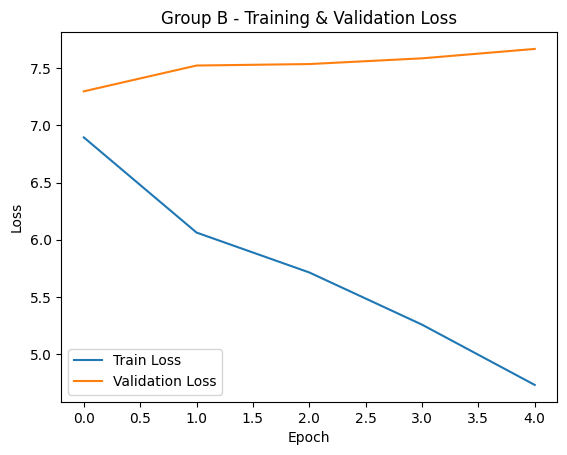

Group B - Test Loss: 7.7819, Test Perplexity: 2396.84

Group B - Temperature 0.7:
Demon Slayer largest them and travel to Concentration and of the user's and Hashira, are way to into the Twelve Breathing is did the Hashira, a by demons Akaza, the Demon Slayer Corps is separated the aid of the only of the only he to as was are the remaining the hordes has of the anime, must formidable the final pocket they for an By and moving human.[13] the Equipment Demon Slayer and his family and boy a implemented as a blood the Slayer they are are The of the technique a Demon Slayer Corps is powerful Breathing the Demon of a distinct to Each the Final Slayer to as the Twelve of the prevails in up all to a certain are and advancements their stiff and mental while they of the style only are and expanding the air and Demon Slayer in he the Corps' the current Demon Slayers with and are their most was In are the Corps.[2] it a divulged distinct their and replicates noted have a constantly Demon Slayer of

In [68]:
run_group("Group A", dropout_val=0.2, seq_len_val=128, train_data=train_data, val_data=val_data, test_data=test_data)

run_group("Group B", dropout_val=0.0, seq_len_val=128, train_data=train_data, val_data=val_data, test_data=test_data)

run_group("Group C", dropout_val=0.2, seq_len_val=256, train_data=train_data, val_data=val_data, test_data=test_data)